[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-reducers.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239428-lesson-2-state-reducers)

# State Reducers 

## Review

We covered a few different ways to define LangGraph state schema, including `TypedDict`, `Pydantic`, or `Dataclasses`.
 
## Goals

Now, we're going to dive into reducers, which specify how state updates are performed on specific keys / channels in the state schema.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.0.0 which is incompatible.
langchain-openai 0.3.35 requires langchain-core<1.0.0,>=0.3.78, but you have langchain-core 1.0.0 which is incompatible.


## Default overwriting state

Let's use a `TypedDict` as our state schema.

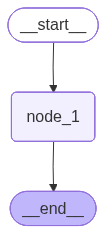

In [2]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
graph.invoke({"foo" : 1})

---Node 1---


{'foo': 2}

Let's look at the state update, `return {"foo": state['foo'] + 1}`.

As discussed before, by default LangGraph doesn't know the preferred way to update the state.
 
So, it will just overwrite the value of `foo` in `node_1`: 

```
return {"foo": state['foo'] + 1}
```
 
If we pass `{'foo': 1}` as input, the state returned from the graph is `{'foo': 2}`.

## Branching

Let's look at a case where our nodes branch.

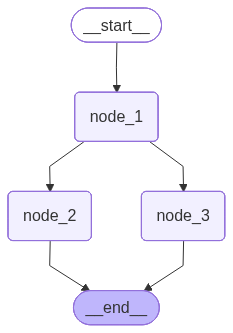

In [4]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")


---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


We see a problem! 

Node 1 branches to nodes 2 and 3.

Nodes 2 and 3 run in parallel, which means they run in the same step of the graph.

They both attempt to overwrite the state *within the same step*. 

This is ambiguous for the graph! Which state should it keep? 

## Reducers

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) give us a general way to address this problem.

They specify how to perform updates.

We can use the `Annotated` type to specify a reducer function. 

For example, in this case let's append the value returned from each node rather than overwriting them.

We just need a reducer that can perform this: `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

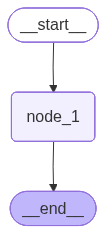

In [6]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

Now, our state key `foo` is a list.

This `operator.add` reducer function will append updates from each node to this list. 

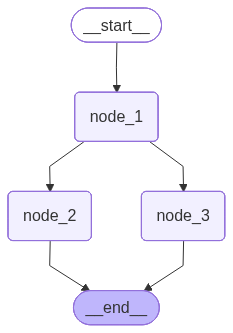

In [8]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We can see that updates in nodes 2 and 3 are performed concurrently because they are in the same step.

In [9]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

Now, let's see what happens if we pass `None` to `foo`.

We see an error because our reducer, `operator.add`, attempts to concatenate `NoneType` pass as input to list in `node_1`. 

In [10]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## Custom Reducers

To address cases like this, [we can also define custom reducers](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state). 

For example, lets define custom reducer logic to combine lists and handle cases where either or both of the inputs might be `None`.

In [11]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

In `node_1`, we append the value 2.

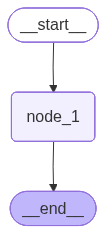

TypeError occurred: can only concatenate list (not "NoneType") to list


In [12]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

Now, try with our custom reducer. We can see that no error is thrown.

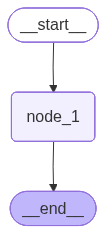

---Node 1---
{'foo': [2]}


In [13]:
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## Messages

In module 1, we showed how to use a built-in reducer, `add_messages`, to handle messages in state.

We also showed that [`MessagesState` is a useful shortcut if you want to work with messages](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate). 

* `MessagesState` has a built-in `messages` key 
* It also has a built-in `add_messages` reducer for this key

These two are equivalent. 

We'll use the `MessagesState` class via `from langgraph.graph import MessagesState` for brevity.


In [14]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    added_key_1: str
    added_key_2: str
    # etc

Let's talk a bit more about usage of the `add_messages` reducer.

In [15]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='e5b9c42b-53cc-4f1d-a7ac-2ac6fdd7a847'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='8a0ea91b-b025-448e-b91d-b0ab4d9743b6'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='9c5df48b-1514-4b20-ae8e-ebdd267fbfc8')]

So we can see that `add_messages` allows us to append messages to the `messages` key in our state.

### Re-writing

Let's show some useful tricks when working with the `add_messages` reducer.

If we pass a message with the same ID as an existing one in our `messages` list, it will get overwritten!

In [16]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

### Removal

`add_messages` also [enables message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/). 

For this, we simply use [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) from `langchain_core`.

In [17]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [18]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

🛒 Final Cart: ['apple', 'banana', 'carrot', 'broccoli']


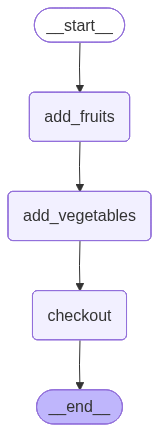

In [19]:
# 1️⃣ Imports
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from typing import List

# 2️⃣ Define the state schema with a reducer
class ShoppingState(BaseModel):
    cart: List[str] = Field(default_factory=list)

    def add_item(self, item: str):
        """Reducer function to add an item to the cart"""
        self.cart.append(item)
        return self

# 3️⃣ Define nodes
def add_fruits(state: ShoppingState):
    for fruit in ["apple", "banana"]:
        state.add_item(fruit)
    return state

def add_vegetables(state: ShoppingState):
    for veg in ["carrot", "broccoli"]:
        state.add_item(veg)
    return state

def checkout(state: ShoppingState):
    print("🛒 Final Cart:", state.cart)
    return state

# 4️⃣ Build graph
builder = StateGraph(ShoppingState)
builder.add_node("add_fruits", add_fruits)
builder.add_node("add_vegetables", add_vegetables)
builder.add_node("checkout", checkout)
builder.add_edge(START, "add_fruits")
builder.add_edge("add_fruits", "add_vegetables")
builder.add_edge("add_vegetables", "checkout")
builder.add_edge("checkout", END)

# 5️⃣ Compile and run
graph = builder.compile()
result = graph.invoke(ShoppingState())

display(Image(graph.get_graph().draw_mermaid_png()))